## **Virus Classification**

+ **Datasets**:  covidx-cxr2

+ **Classes**: Normal, Covid_19



In [1]:
import os
import cv2
import platform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

os.environ['PYTHONHASHSEED'] = '73'

seed = 73
random.seed(seed)
np.random.seed(seed)

print(platform.platform())
%matplotlib inline

Linux-5.15.133+-x86_64-with-debian-buster-sid


In [2]:
!nvidia-smi

Wed Mar 27 03:45:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              28W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!ls /kaggle/input/

chest-xray-pneumonia  covidx-cxr2


In [4]:
MyDrive = '/kaggle/working'
clear_output()

DataDir = '../input/covidx-cxr2'
PneumoniaDir = '../input/chest-xray-pneumonia/chest_xray'

print('> Covid 19 dir:', os.listdir(DataDir))
print('> Pneumonia dir:', os.listdir(PneumoniaDir))

> Covid 19 dir: ['val.txt', 'test.txt', 'train.txt', 'val', 'test', 'train']
> Pneumonia dir: ['chest_xray', '__MACOSX', 'val', 'test', 'train']


## **Data Preparation**

In [5]:
from tqdm import tqdm

train_image_dir = PneumoniaDir + '/train'
test_image_dir = PneumoniaDir + '/test'
val_image_dir = PneumoniaDir + '/val'

img_map = []

def prepareData(Dir, strat):
    cats = ["NORMAL","PNEUMONIA"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(train_image_dir,'train')
prepareData(test_image_dir,'test')
prepareData(val_image_dir, 'val')

img_map = pd.DataFrame(img_map).sample(frac = 1, random_state=seed)

100%|██████████| 8/8 [00:00<00:00, 82850.45it/s]


### **Getting image path and labels from *.txt files**

In [6]:
#ricord, rsna, cohen, actmed, sirm, 
def getClass(label):
    if label == 'negative':
        return 'NORMAL'
    if label == 'positive':
        return 'COVID'

def get_image_map(txt_path, strat):
    train_txt = open(txt_path, 'r')
    Lines = train_txt.readlines()
    paths = []
    
    img_formats = ['jpg', 'jpeg', 'png']
    
    for n, line in enumerate(Lines):
        querywords = line.split()

        if len(querywords) == 4:
            image_id = querywords[0]
            image_path = DataDir + '/' + strat + '/'+ querywords[1]
            label = querywords[2]

        if len(querywords) == 5:
            image_id = querywords[0]
            image_path = DataDir + '/' + strat + '/'+ querywords[2]
            label = querywords[3]
            
        for img_type in img_formats:
            if img_type in line:
                obj_ = {'path': image_path, 'label': getClass(label)}
                if (('positive' in line) | ('negative' in line)):
                    paths.append(obj_)

    paths_df = pd.DataFrame(paths)
    return paths_df

In [7]:
train_map = get_image_map(DataDir + '/train.txt', 
                          strat='train').sample(frac = 1, random_state=73)

test_map = get_image_map(DataDir + '/test.txt',
                         strat='test').sample(frac = 1, random_state=73)

In [8]:
img_path_map = pd.concat([img_map, train_map, test_map], axis=0).sample(frac = 1, random_state=73)
img_path_map.head()

,path,label
62232,../input/covidx-cxr2/train/sub-S328618_ses-E57...,COVID
3312,../input/covidx-cxr2/test/sub-S09371_ses-E1751...,COVID
25957,../input/covidx-cxr2/train/sub-S10645_ses-E200...,COVID
18426,../input/covidx-cxr2/train/A790978-12-29-1900-...,COVID
10655,../input/covidx-cxr2/train/c69a011e-1c12-4866-...,NORMAL


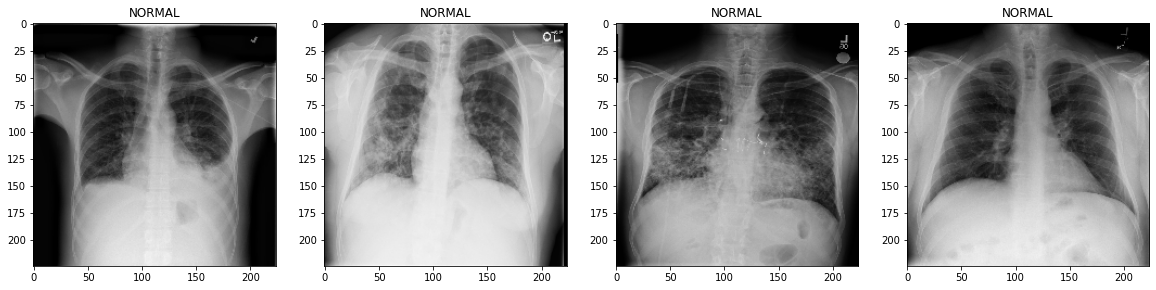

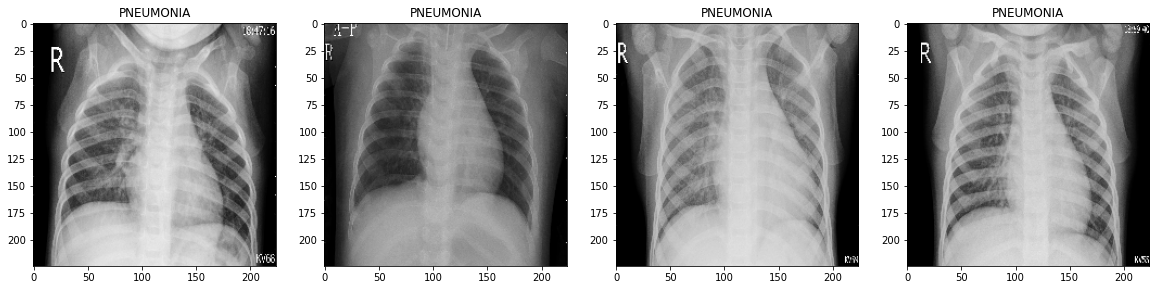

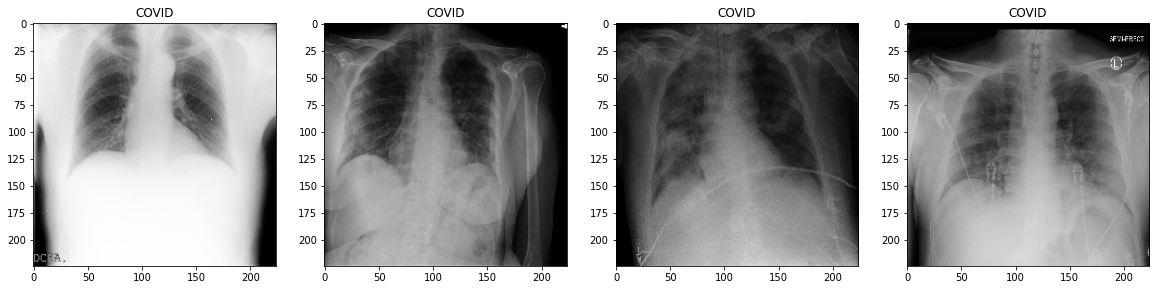

In [9]:
import matplotlib.pyplot as plt

def print_images(samples): 
    images = samples["path"].to_numpy()
    labels = samples['label'].to_numpy()
    
    fig=plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1
    
    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        fig.add_subplot(rows,columns,i + 1)
        title = '{}'.format(labels[i])
        
        Sample_image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
        
        plt.imshow(Sample_image, cmap='gray')
        plt.title(title)
        
    plt.show()
        
print_images(img_path_map[img_path_map['label']=="NORMAL"].iloc[0:4])
print_images(img_path_map[img_path_map['label']=="PNEUMONIA"].iloc[0:4])
print_images(img_path_map[img_path_map['label']=="COVID"].iloc[0:4])

%matplotlib inline


### **Visualization**

In [10]:
def getLabelCount(frame):
    label_count = pd.Series(frame['label'].values.ravel()).value_counts()
    n_classes = (label_count)
    return label_count

label_count = getLabelCount(img_path_map)
print(label_count)

COVID        61440
NORMAL       16487
PNEUMONIA     4273
dtype: int64


In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

features = img_path_map['path'].to_numpy()
labels = img_path_map['label'].to_numpy()

stratified_sample = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=73)

In [12]:
for train_index, test_index in stratified_sample.split(features, labels):
    X_train, test_X = features[train_index], features[test_index]
    y_train, test_y = labels[train_index], labels[test_index]
    
half_size = np.int(len(test_X) / 2)
X_test, y_test = test_X[0:half_size], test_y[0:half_size]
X_val, y_val = test_X[half_size:], test_y[half_size:]

In [13]:
train_map = pd.DataFrame()
train_map['path'], train_map['label'] = X_train, y_train
test_map = pd.DataFrame()
test_map['path'], test_map['label'] = X_test, y_test
val_map = pd.DataFrame()
val_map['path'], val_map['label'] = X_val, y_val

In [14]:
print('> {} train size'.format(X_train.shape[0]))
print('> {} test size'.format(X_test.shape[0]))
print('> {} val size'.format(X_val.shape[0]))

> 65760 train size
> 8220 test size
> 8220 val size


In [15]:
import cv2
import time
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
ia.seed(73)

ColorCh = 3
IMG_SIZE = 224
input_shape=(IMG_SIZE, IMG_SIZE, ColorCh)

classes = ("COVID", "NORMAL","PNEUMONIA")
CATEGORIES = sorted(classes)

print('> Classes:',CATEGORIES)

> Classes: ['COVID', 'NORMAL', 'PNEUMONIA']


In [16]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255, 
                             horizontal_flip=True,
                             brightness_range=[1.0,1.3],
                             rotation_range=15,
                             #zoom_range=0.2
                            )

In [17]:
batch_size = 32

def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          x_col="path",
                          y_col="label",
                          batch_size=batch_size,
                          seed=seed,
                          shuffle=False,
                          class_mode="sparse",
                          color_mode="rgb",
                          save_format="jpeg",
                          target_size=(IMG_SIZE,IMG_SIZE)             
             )
    
    return generator

In [18]:
train_df = train_map.sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

print('> label count for train set')
getLabelCount(train_df)

Found 65760 validated image filenames belonging to 3 classes.
> label count for train set


COVID        49152
NORMAL       13190
PNEUMONIA     3418
dtype: int64

In [19]:
test_df = test_map.sample(frac=1, random_state=seed)
test_generator = get_generator(test_df)

print('> label count for test set')
getLabelCount(test_df)

Found 8220 validated image filenames belonging to 3 classes.
> label count for test set


COVID        6131
NORMAL       1660
PNEUMONIA     429
dtype: int64

In [20]:
val_df = val_map.sample(frac=1, random_state=seed)
val_generator = get_generator(val_df)

print('> label count for val set')
getLabelCount(val_df)

Found 8220 validated image filenames belonging to 3 classes.
> label count for val set


COVID        6157
NORMAL       1637
PNEUMONIA     426
dtype: int64

In [21]:
print('> input shape:', input_shape)

> input shape: (224, 224, 3)


In [22]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add, add
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import regularizers

kernel_regularizer = regularizers.l2(0.0001)

final_activation = 'softmax'
entropy = 'sparse_categorical_crossentropy'
n_classes = len(CATEGORIES)
print('> {} classes'.format(n_classes))

> 3 classes


In [23]:
def FCLayers(baseModel):
    baseModel.trainable = True
    headModel = baseModel.output
    headModel = Dropout(0.5, seed=73)(headModel)
    headModel = Dense(n_classes, activation=final_activation)(headModel)
    model = Model(inputs = baseModel.input, outputs = headModel)
    5
    return model

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, LayerNormalization, GlobalAveragePooling1D

CFGS = {
    'swin_tiny_224': dict(input_size=(224, 224), window_size=7, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24]),
    'swin_small_224': dict(input_size=(224, 224), window_size=7, embed_dim=96, depths=[2, 2, 18, 2], num_heads=[3, 6, 12, 24]),
    'swin_base_224': dict(input_size=(224, 224), window_size=7, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    'swin_base_384': dict(input_size=(384, 384), window_size=12, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    'swin_large_224': dict(input_size=(224, 224), window_size=7, embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48]),
    'swin_large_384': dict(input_size=(384, 384), window_size=12, embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48])
}


class Mlp(tf.keras.layers.Layer):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0., prefix=''):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = Dense(hidden_features, name=f'{prefix}/mlp/fc1')
        self.fc2 = Dense(out_features, name=f'{prefix}/mlp/fc2')
        self.drop = Dropout(drop)

    def call(self, x):
        x = self.fc1(x)
        x = tf.keras.activations.gelu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    B, H, W, C = x.get_shape().as_list()
    x = tf.reshape(x, shape=[-1, H // window_size,
                   window_size, W // window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, shape=[-1, window_size, window_size, C])
    return windows


def window_reverse(windows, window_size, H, W, C):
    x = tf.reshape(windows, shape=[-1, H // window_size,
                   W // window_size, window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    x = tf.reshape(x, shape=[-1, H, W, C])
    return x


class WindowAttention(tf.keras.layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0., prefix=''):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.prefix = prefix

        self.qkv = Dense(dim * 3, use_bias=qkv_bias,
                         name=f'{self.prefix}/attn/qkv')
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, name=f'{self.prefix}/attn/proj')
        self.proj_drop = Dropout(proj_drop)

    def build(self, input_shape):
        self.relative_position_bias_table = self.add_weight(f'{self.prefix}/attn/relative_position_bias_table',
                                                            shape=(
                                                                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1), self.num_heads),
                                                            initializer=tf.initializers.Zeros(), trainable=True)

        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords = np.stack(np.meshgrid(coords_h, coords_w, indexing='ij'))
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :,
                                         None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1).astype(np.int64)
        self.relative_position_index = tf.Variable(initial_value=tf.convert_to_tensor(
            relative_position_index), trainable=False, name=f'{self.prefix}/attn/relative_position_index')
        self.built = True

    def call(self, x, mask=None):
        B_, N, C = x.get_shape().as_list()
        qkv = tf.transpose(tf.reshape(self.qkv(
            x), shape=[-1, N, 3, self.num_heads, C // self.num_heads]), perm=[2, 0, 3, 1, 4])
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ tf.transpose(k, perm=[0, 1, 3, 2]))
        relative_position_bias = tf.gather(self.relative_position_bias_table, tf.reshape(
            self.relative_position_index, shape=[-1]))
        relative_position_bias = tf.reshape(relative_position_bias, shape=[
                                            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1])
        relative_position_bias = tf.transpose(
            relative_position_bias, perm=[2, 0, 1])
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]  # tf.shape(mask)[0]
            attn = tf.reshape(attn, shape=[-1, nW, self.num_heads, N, N]) + tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32)
            attn = tf.reshape(attn, shape=[-1, self.num_heads, N, N])
            attn = tf.nn.softmax(attn, axis=-1)
        else:
            attn = tf.nn.softmax(attn, axis=-1)

        attn = self.attn_drop(attn)

        x = tf.transpose((attn @ v), perm=[0, 2, 1, 3])
        x = tf.reshape(x, shape=[-1, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


def drop_path(inputs, drop_prob, is_training):
    if (not is_training) or (drop_prob == 0.):
        return inputs

    # Compute keep_prob
    keep_prob = 1.0 - drop_prob

    # Compute drop_connect tensor
    random_tensor = keep_prob
    shape = (tf.shape(inputs)[0],) + (1,) * \
        (len(tf.shape(inputs)) - 1)
    random_tensor += tf.random.uniform(shape, dtype=inputs.dtype)
    binary_tensor = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_prob) * binary_tensor
    return output


class DropPath(tf.keras.layers.Layer):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        return drop_path(x, self.drop_prob, training)


class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path_prob=0., norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"
        self.prefix = prefix

        self.norm1 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm1')
        self.attn = WindowAttention(dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
                                    qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, prefix=self.prefix)
        self.drop_path = DropPath(
            drop_path_prob if drop_path_prob > 0. else 0.)
        self.norm2 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm2')
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       drop=drop, prefix=self.prefix)

    def build(self, input_shape):
        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = np.zeros([1, H, W, 1])
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            img_mask = tf.convert_to_tensor(img_mask)
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size])
            attn_mask = tf.expand_dims(
                mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(
                initial_value=attn_mask, trainable=False, name=f'{self.prefix}/attn_mask')
        else:
            self.attn_mask = None

        self.built = True

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=[-1, H, W, C])

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=[-1, self.window_size * self.window_size, C])

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # merge windows
        attn_windows = tf.reshape(
            attn_windows, shape=[-1, self.window_size, self.window_size, C])
        shifted_x = window_reverse(attn_windows, self.window_size, H, W, C)

        # reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[
                        self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
        x = tf.reshape(x, shape=[-1, H * W, C])

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, input_resolution, dim, norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = Dense(2 * dim, use_bias=False,
                               name=f'{prefix}/downsample/reduction')
        self.norm = norm_layer(epsilon=1e-5, name=f'{prefix}/downsample/norm')

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = tf.reshape(x, shape=[-1, H, W, C])

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = tf.concat([x0, x1, x2, x3], axis=-1)
        x = tf.reshape(x, shape=[-1, (H // 2) * (W // 2), 4 * C])

        x = self.norm(x)
        x = self.reduction(x)

        return x


class BasicLayer(tf.keras.layers.Layer):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path_prob=0., norm_layer=LayerNormalization, downsample=None, use_checkpoint=False, prefix=''):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = tf.keras.Sequential([SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                           num_heads=num_heads, window_size=window_size,
                                           shift_size=0 if (
                                               i % 2 == 0) else window_size // 2,
                                           mlp_ratio=mlp_ratio,
                                           qkv_bias=qkv_bias, qk_scale=qk_scale,
                                           drop=drop, attn_drop=attn_drop,
                                           drop_path_prob=drop_path_prob[i] if isinstance(
                                               drop_path_prob, list) else drop_path_prob,
                                           norm_layer=norm_layer,
                                           prefix=f'{prefix}/blocks{i}') for i in range(depth)])
        if downsample is not None:
            self.downsample = downsample(
                input_resolution, dim=dim, norm_layer=norm_layer, prefix=prefix)
        else:
            self.downsample = None

    def call(self, x):
        x = self.blocks(x)

        if self.downsample is not None:
            x = self.downsample(x)
        return x


class PatchEmbed(tf.keras.layers.Layer):
    def __init__(self, img_size=(224, 224), patch_size=(4, 4), in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__(name='patch_embed')
        patches_resolution = [img_size[0] //
                              patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = Conv2D(embed_dim, kernel_size=patch_size,
                           strides=patch_size, name='proj')
        if norm_layer is not None:
            self.norm = norm_layer(epsilon=1e-5, name='norm')
        else:
            self.norm = None

    def call(self, x):
        B, H, W, C = x.get_shape().as_list()
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        x = tf.reshape(
            x, shape=[-1, (H // self.patch_size[0]) * (W // self.patch_size[0]), self.embed_dim])
        if self.norm is not None:
            x = self.norm(x)
        return x


class SwinTransformerModel(tf.keras.Model):
    def __init__(self, model_name='swin_tiny_patch4_window7_224', include_top=False,
                 img_size=(224, 224), patch_size=(4, 4), in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=LayerNormalization, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__(name=model_name)

        self.include_top = include_top

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute postion embedding
        if self.ape:
            self.absolute_pos_embed = self.add_weight('absolute_pos_embed',
                                                      shape=(
                                                          1, num_patches, embed_dim),
                                                      initializer=tf.initializers.Zeros())

        self.pos_drop = Dropout(drop_rate)

        # stochastic depth
        dpr = [x for x in np.linspace(0., drop_path_rate, sum(depths))]

        # build layers
        self.basic_layers = tf.keras.Sequential([BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                                                input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                                  patches_resolution[1] // (2 ** i_layer)),
                                                depth=depths[i_layer],
                                                num_heads=num_heads[i_layer],
                                                window_size=window_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path_prob=dpr[sum(depths[:i_layer]):sum(
                                                    depths[:i_layer + 1])],
                                                norm_layer=norm_layer,
                                                downsample=PatchMerging if (
                                                    i_layer < self.num_layers - 1) else None,
                                                use_checkpoint=use_checkpoint,
                                                prefix=f'layers{i_layer}') for i_layer in range(self.num_layers)])
        self.norm = norm_layer(epsilon=1e-5, name='norm')
        self.avgpool = GlobalAveragePooling1D()
        if self.include_top:
            self.head = Dense(num_classes, name='head')
        else:
            self.head = None

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        x = self.basic_layers(x)
        x = self.norm(x)
        x = self.avgpool(x)
        return x

    def call(self, x):
        x = self.forward_features(x)
        if self.include_top:
            x = self.head(x)
        return x


def SwinTransformer(model_name='swin_tiny_224', num_classes=1000, include_top=True, pretrained=True, use_tpu=False, cfgs=CFGS):
    cfg = cfgs[model_name]
    net = SwinTransformerModel(
        model_name=model_name, include_top=include_top, num_classes=num_classes, img_size=cfg['input_size'], window_size=cfg[
            'window_size'], embed_dim=cfg['embed_dim'], depths=cfg['depths'], num_heads=cfg['num_heads']
    )
    net(tf.keras.Input(shape=(cfg['input_size'][0], cfg['input_size'][1], 3)))
    if pretrained is True:
        url = f'https://github.com/rishigami/Swin-Transformer-TF/releases/download/v0.1-tf-swin-weights/{model_name}.tgz'
        pretrained_ckpt = tf.keras.utils.get_file(
            model_name, url, untar=True)
    else:
        pretrained_ckpt = pretrained

    if pretrained_ckpt:
        if tf.io.gfile.isdir(pretrained_ckpt):
            pretrained_ckpt = f'{pretrained_ckpt}/{model_name}.ckpt'

        if use_tpu:
            load_locally = tf.saved_model.LoadOptions(
                experimental_io_device='/job:localhost')
            net.load_weights(pretrained_ckpt, options=load_locally)
        else:
            net.load_weights(pretrained_ckpt)

    return net

In [25]:
IMAGE_SIZE=[224, 224]
CLASSES = ['normal', 'other_pneumonia', 'COVID-19']

def load_swin_transformer():
    img_adjust_layer = tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), mode="torch"), input_shape=[*IMAGE_SIZE, 3])
    pretrained_model = SwinTransformer('swin_tiny_224', num_classes=len(CLASSES), include_top=False, pretrained=True, use_tpu=True)
    model = tf.keras.Sequential([
        img_adjust_layer,
        pretrained_model,
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    return model

load_swin_transformer().summary()

102039552/102036641 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
swin_tiny_224 (SwinTransform (None, 768)               27769058  
_________________________________________________________________
dense (Dense)                (None, 3)                 2307      
Total params: 27,771,365
Trainable params: 27,521,661
Non-trainable params: 249,704
_________________________________________________________________


In [26]:
def getMetrics(name, type_):


        if type_ == 'accuracy':
            return 'accuracy'
        if type_ == 'loss':
            return 'loss'
        if type_ == 'val_accuracy':
            return 'val_accuracy'
        if type_ == 'val_loss':
            return 'val_loss'

In [30]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
          
EPOCHS = 15
patience = 4

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8
        
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        
def getCallbacks(name):
    class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if ((logs.get(getMetrics(name,'accuracy'))>=0.999)):
                print("\nLimits Reached cancelling training!")
                self.model.stop_training = True

            
    end_callback = myCallback()

    lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

    lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

    early_stopping = EarlyStopping(patience = patience, monitor=getMetrics(name, 'val_loss'),
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00030)


    checkpoint_filepath = name + '_Weights.h5'

    model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor=getMetrics(name, 'val_loss'),
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

    import datetime
    log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  
    tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

    return [end_callback, 
             lr_callback, 
             model_checkpoints,
             early_stopping,
             #tensorboard_callback,
             lr_plat
            ]


SwinTransformer_callbacks = getCallbacks('SwinTransformer')


In [31]:
def CompileModel(name, model):
    model.compile(optimizer='adam', loss=entropy, metrics=["accuracy"])
    return model

def FitModel(model, name):


    callbacks_ = SwinTransformer_callbacks

    history = model.fit(train_generator, 
                        epochs=EPOCHS,
                        callbacks=callbacks_,
                        validation_data = val_generator,
                        steps_per_epoch=(len(train_generator.labels) / 80),
                        validation_steps=(len(val_generator.labels) / 80),
                       )
    
    model.load_weights(name + '_Weights.h5')

    final_accuracy_avg = np.mean(history.history[getMetrics(name, "val_accuracy")][-5:])

    final_loss = history.history[getMetrics(name, "val_loss")][-1]
  
    group = {history: 'history', name: 'name', model: 'model', final_accuracy_avg:'acc', final_loss: 'loss'}

    print('\n')
    print('---'*15)
    print(name,' Model')
    print('Total Epochs :', len(history.history[getMetrics(name, 'loss')]))    
    print('Restoring best Weights')
    
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('---'*15)
    print('Best Epoch :', index)
    print('---'*15)
    
    train_accuracy = history.history[getMetrics(name, 'accuracy')][index]
    train_loss = history.history[getMetrics(name, 'loss')][index]
    
    val_accuracy = history.history[getMetrics(name, 'val_accuracy')][index]
    val_loss = history.history[getMetrics(name, 'val_loss')][index]

    print('Accuracy on train:', train_accuracy,
          '\tLoss on train:', train_loss)
    
    print('Accuracy on val:', val_accuracy ,
          '\tLoss on val:', val_loss)
    print('---'*15)

    return model, history

In [32]:
def BuildModel(name):

    if name == 'SwinTransformer':
        prepared_model = load_swin_transformer()
        
    compiled_model = CompileModel(name, prepared_model)
    return compiled_model

In [ ]:
s_compiled_model = BuildModel('SwinTransformer')
s_model, s_history = FitModel(s_compiled_model, 'SwinTransformer')

Epoch 1/15
822/822 [==============================] - 1047s 1s/step - loss: 0.5936 - accuracy: 0.7760 - val_loss: 0.3918 - val_accuracy: 0.8438

Epoch 00001: val_loss improved from inf to 0.39183, saving model to SwinTransformer_Weights.h5
Epoch 2/15
822/822 [==============================] - 875s 1s/step - loss: 0.4005 - accuracy: 0.8441 - val_loss: 0.3043 - val_accuracy: 0.8832

Epoch 00002: val_loss improved from 0.39183 to 0.30431, saving model to SwinTransformer_Weights.h5
Epoch 3/15
621/822 [=====================>........] - ETA: 2:57 - loss: 0.3392 - accuracy: 0.8705

In [ ]:
%matplotlib inline
def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [ ]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix

def test_set_results(pred_value, n=1):    
    y_test = test_generator.labels
    X_test, _ = test_generator.next()
    
    corr_pred = metrics.confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Dense Output {}'.format(n))
    plt.show()
    
    n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_generator.labels, pred_value, target_names=CATEGORIES))

In [ ]:
def printResults(name, model):
    predictions = model.predict(test_generator, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [ ]:
def model_summary(model, history, name):
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('Best Epochs: ', index)
    
    if name == 'GoogLeNet':
        results = model.evaluate(test_generator, verbose=1)
        loss, output3_loss, output1_loss, output2_loss, output3_accuracy, output1_accuracy, output2_accuracy = results
        
        for i in range(3):
            n = i + 1
            out_layer = 'Output Layer {}'.format(n)
            
            if n == 1:
                test_accuracy = output1_accuracy
                test_loss = output1_loss

            if n == 2:
                test_accuracy = output2_accuracy
                test_loss = output2_loss
                
            if n == 3:
                test_accuracy = output3_accuracy
                test_loss = output3_loss
                
                
            output_name = 'output{}_'.format(n)
            train_accuracy, train_loss = history.history[output_name + 'accuracy'][index], history.history[output_name + 'loss'][index]
            
  
            print_graph(output_name + 'loss', index, history)
            print_graph(output_name + 'accuracy', index, history)
        
            print('---'*15)  
            print('GoogLeNet Dense output {}:'.format(n))
            
            print('> Accuracy on train :'.format(out_layer), train_accuracy, 
                  '\tLoss on train:',train_loss)
        
            print('> Accuracy on test :'.format(out_layer), test_accuracy,
                  '\tLoss on test:',test_loss)
            
            print('---'*15)
            print('> predicting test')
            print('---'*15)
            
            predictions = model.predict(test_generator, verbose=1)
            preds = np.argmax(predictions[i], axis=1)
            test_set_results(preds, n)
                
    else:
        test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
        
        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        
        print('---'*15) 
        print(name)
        print('> Accuracy on train:',train_accuracy, 
              '\tLoss on train:',train_loss)
        
        print('> Accuracy on test:',test_accuracy,
              '\tLoss on test:',test_loss)
        
        print('---'*15)
        print('> predicting test')
        print('---'*15)
        
        printResults(name, model)

In [ ]:
from IPython.display import FileLink

In [ ]:
batch_size = 32

def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          x_col="path",
                          y_col="label",
                          batch_size=batch_size,
                          seed=seed,
                          shuffle=False,
                          class_mode="sparse",
                          color_mode="rgb",
                          save_format="jpeg",
                          target_size=(IMG_SIZE,IMG_SIZE)             
             )
    
    return generator

In [ ]:
s_model.save('Transformer_model.h5')
FileLink(r'./Transformer_model.h5')

In [ ]:
a=1
while a=1:
    b=a